# Grunnleggende

In [21]:
### Importerer nødvendige biblioteker
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from statsmodels import api as sm


from poweranalysis.weather.frost_client import FrostDataRetriever
from poweranalysis.config import Config
from poweranalysis.models.hdd import HDDModel

In [3]:
### Laster inn data, vil du se mer; ref build_dataset.py
df_daily = pd.read_parquet(Config.out_daily)
df_hourly = pd.read_parquet(Config.out_hourly)

In [4]:
df_daily.head()

,Forbruk (kWh),Pris (øre/kWh),Nettleie (øre/kWh),air_temperature,relative_humidity,wind_speed,wind_from_direction,sum(precipitation_amount PT1H),hour,dayofweek,is_weekend,month
Tidspunkt,,,,,,,,,,,,
2025-08-01,3.576,21.877667,45.286667,20.273913,81.521739,2.039130,172.652174,0.0000,11.5,4.0,0.0,8.0
2025-08-02,3.630,16.449558,45.286667,18.425000,87.916667,1.300000,256.083333,0.0000,11.5,5.0,1.0,8.0
2025-08-03,3.105,11.334342,45.286667,19.941667,79.791667,2.033333,182.125000,0.0000,11.5,6.0,1.0,8.0
2025-08-04,3.705,17.420217,45.286667,17.287500,85.625000,1.550000,157.500000,0.0500,11.5,0.0,0.0,8.0
2025-08-05,3.520,6.222729,45.286667,16.925000,66.916667,4.000000,194.875000,0.0875,11.5,1.0,0.0,8.0


# EDA

In [ ]:
cols = ["air_temperature", "Forbruk (kWh)"]

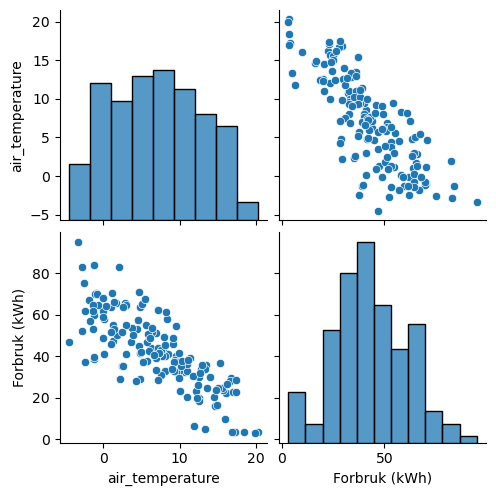

In [ ]:

df = df_daily[cols].dropna()
sns.pairplot(df)

<Axes: >

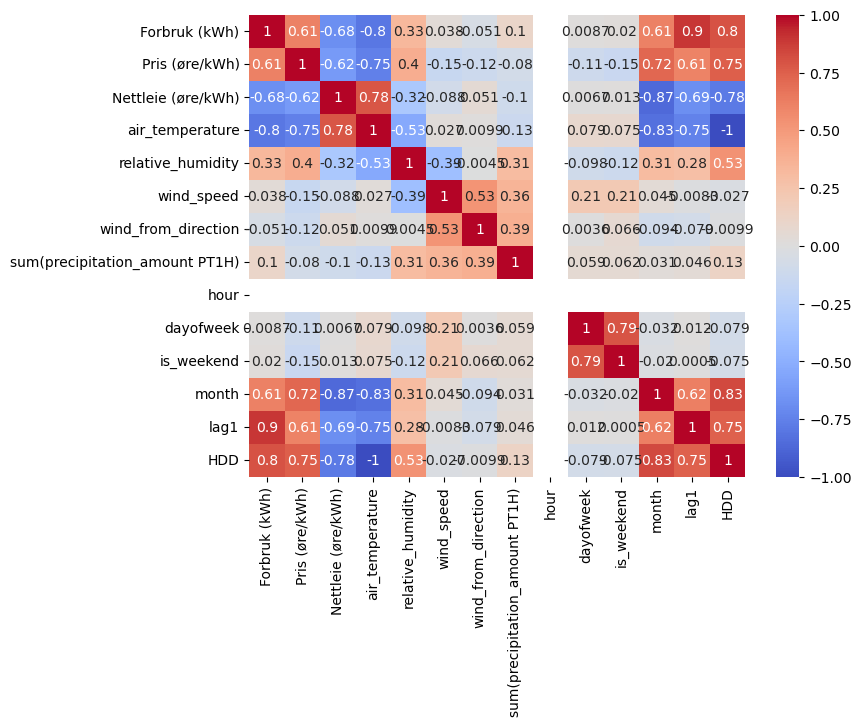

In [29]:
## Heatmap av korrelasjon mellom variabler
plt.figure(figsize=(8, 6))
sns.heatmap(df_daily.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# HDD modellering

In [12]:
model = HDDModel(temp_col="air_temperature", target_col="Forbruk (kWh)")
best_base = model.find_optimal_base(df)
res = model.fit(df)
print(f"Optimal base temperature: {best_base:.2f} °C")
display(model.summary())

Optimal base temperature: 20.50 °C


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Forbruk (kWh)   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     268.1
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           2.74e-35
Time:                        15:26:39   Log-Likelihood:                -580.60
No. Observations:                 153   AIC:                             1165.
Df Residuals:                     151   BIC:                             1171.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.8926      2.195      4.506      0.000       5.555      14.230
air_temperature     2.4279      0.148     16.373      0.000       2.135       2.721
==============================================================================
Omnibus:                        1.151   Durbin-Watson:                   0.569
Prob(Omnibus):                  0.563   Jarque-Bera (JB):                0.792
Skew:                          -0.149   Prob(JB):                        0.673
Kurtosis:                       3.189   Cond. No.                         37.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
y_true = df["Forbruk (kWh)"]
y_pred = model.predict(df)

mae = mean_absolute_error(df_daily["Forbruk (kWh)"], y_pred)
rmse = root_mean_squared_error(df_daily["Forbruk (kWh)"], y_pred)

print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

MAE: 8.29
RMSE: 10.76


In [20]:
naive = df_daily["Forbruk (kWh)"].shift(1)

mae_naive = mean_absolute_error(df_daily["Forbruk (kWh)"][1:], naive[1:])
rmse_naive = root_mean_squared_error(df_daily["Forbruk (kWh)"][1:], naive[1:])

print("MAE naive:", round(mae_naive, 2))
print("RMSE naive:", round(rmse_naive, 2))

MAE naive: 6.31
RMSE naive: 8.12


In [ ]:
df_daily["lag1"] = df_daily["Forbruk (kWh)"].shift(1)
df_daily["HDD"] = model.compute_hdd(df_daily["air_temperature"], float(model.base_temp))

df_model = df_daily.dropna()

X = sm.add_constant(df_model[["HDD", "lag1"]])
y = df_model["Forbruk (kWh)"]

m_arx = sm.OLS(y, X).fit()


                            OLS Regression Results                            
Dep. Variable:          Forbruk (kWh)   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     387.3
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           9.45e-60
Time:                        15:32:48   Log-Likelihood:                -513.79
No. Observations:                 152   AIC:                             1034.
Df Residuals:                     149   BIC:                             1043.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4831      1.585      1.567      0.1

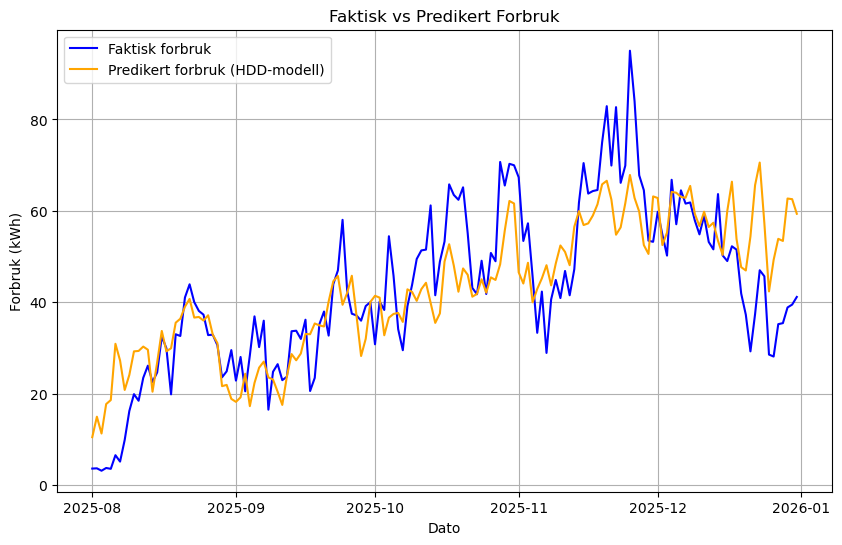

In [25]:
### Plotter predikert vs faktisk forbruk
plt.figure(figsize=(10, 6))
plt.plot(df_daily.index, df_daily["Forbruk (kWh)"], label="Faktisk forbruk", color="blue")
plt.plot(df_daily.index, y_pred, label="Predikert forbruk (HDD-modell)", color="orange")
plt.xlabel("Dato")
plt.ylabel("Forbruk (kWh)")
plt.title("Faktisk vs Predikert Forbruk")
plt.legend()
plt.grid()
plt.show()

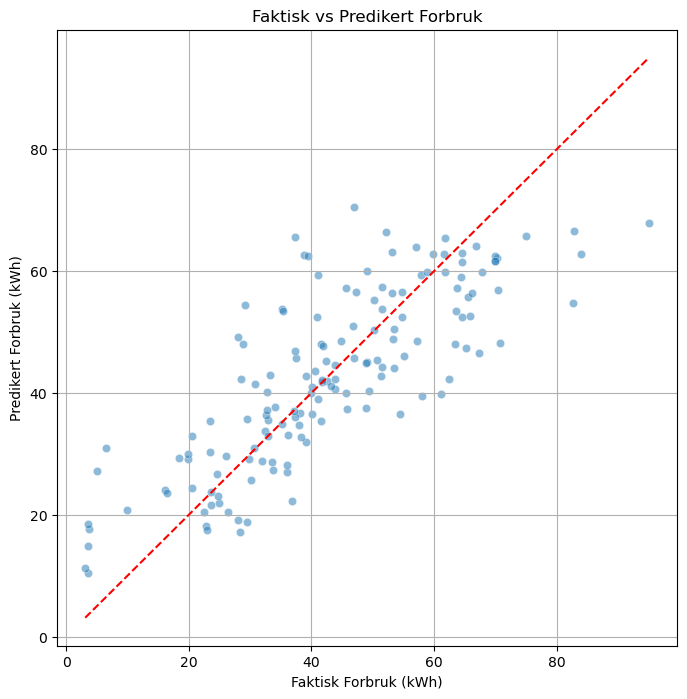

In [26]:
### scatter plot av faktisk vs predikert forbruk
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_daily["Forbruk (kWh)"], y=y_pred, alpha=0.5)
plt.plot([df_daily["Forbruk (kWh)"].min(), df_daily["Forbruk (kWh)"].max()], [df_daily["Forbruk (kWh)"].min(), df_daily["Forbruk (kWh)"].max()], color="red", linestyle="--")
plt.xlabel("Faktisk Forbruk (kWh)")
plt.ylabel("Predikert Forbruk (kWh)")
plt.title("Faktisk vs Predikert Forbruk")
plt.grid()
plt.show()

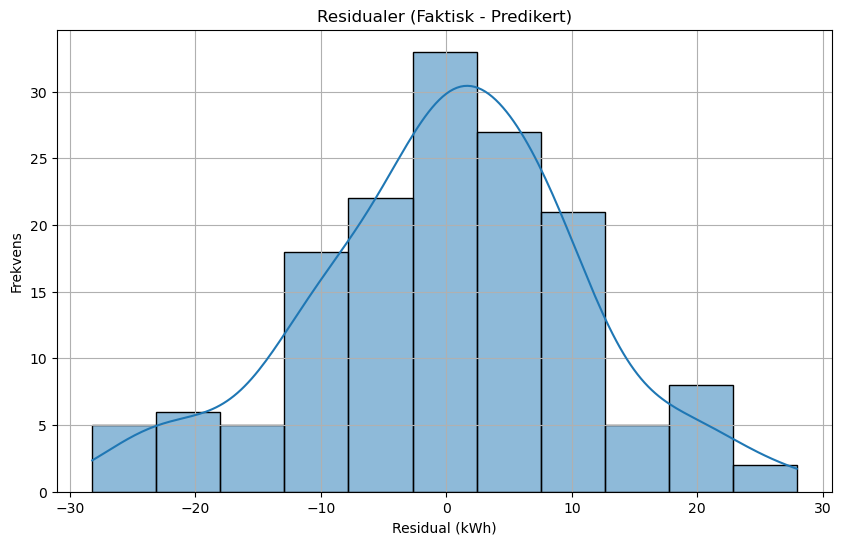

In [27]:
resid = y - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(resid, kde=True)
plt.title("Residualer (Faktisk - Predikert)")
plt.xlabel("Residual (kWh)")
plt.ylabel("Frekvens")
plt.grid()
plt.show()